In [368]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from plotnine import *
from statsmodels.tsa.arima.model import ARIMA

In [253]:
calendar = pd.read_csv("calendar_afcs2020.csv")
sales = pd.read_csv("sales_train_evaluation_afcs2020.csv")
train = pd.read_csv("sales_train_validation_afcs2020.csv")
sample_submission = pd.read_csv("sample_submission_afcs2020.csv")
price = pd.read_csv("sell_prices_afcs2020.csv")

In [245]:
train.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_2_001_CA_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_2_002_CA_3_validation,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
2,HOBBIES_2_003_CA_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,3
3,HOBBIES_2_004_CA_3_validation,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,HOBBIES_2_005_CA_3_validation,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [61]:
price["id"] = price["item_id"] + "_" + price["store_id"] + "_validation"
calendar['date'] = pd.to_datetime(calendar['date'])
datetime = calendar[["date","d"]].copy()

In [ ]:
# Moving Average (MA)
def MA(train, h):
    
    # fit model
    model = ARIMA(train, order=(0, 0, 1))
    model_fit = model.fit()
    
    # make prediction
    start_index = len(data) + 1
    end_index = start_index + h
    fc = model_fit.predict(start=start_index, end=end_index)
    
    return fc

In [507]:
moving_average = True

c = 0
h = 28
output = {}


for i in range(1, len(train) + 1):
    fc = []
    item_train = train.iloc[(i-1):i].iloc[:,1:].T.reset_index()
    item_train = pd.merge(left=item_train,right=datetime,left_on="index",right_on="d",how="left")
    item_train.drop(["d","index"],axis=1,inplace=True)
    item_train = item_train.rename({"date":"ds",item_train.columns[0]:"y"},axis=1)
    item_train = item_train[item_train.columns[::-1]]
    
    item_sales = sales.iloc[(i-1):i][sales.columns[-(h+1):]].iloc[:,1:].T.reset_index()
    item_sales = pd.merge(left=item_sales,right=datetime,left_on="index",right_on="d",how="left")
    item_sales.drop(["d","index"],axis=1,inplace=True)
    item_sales = item_sales.rename({"date":"ds",item_sales.columns[0]:"y"},axis=1)
    
    ts_train = item_train.iloc[-(h*8):,:].copy()
    ts_test = item_sales[item_sales.columns[::-1]]
    
    data = ts_train["y"].tolist()
    
    if moving_average:
        pred = MA(data, h)[1:]
    
    fc.append(train.id[(i-1)])
    fc.extend(pred)
    output[(i-1)] = fc
    
output_df = pd.DataFrame.from_dict(output, orient='index', columns=sample_submission.columns)
output_df
# output_df.to_csv('output.csv', index=False)

/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
/usr/local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_2_001_CA_3_validation,0.174045,0.174045,0.174045,0.174045,0.174045,0.174045,0.174045,0.174045,0.174045,...,0.174045,0.174045,0.174045,0.174045,0.174045,0.174045,0.174045,0.174045,0.174045,0.174045
1,HOBBIES_2_002_CA_3_validation,0.169576,0.169576,0.169576,0.169576,0.169576,0.169576,0.169576,0.169576,0.169576,...,0.169576,0.169576,0.169576,0.169576,0.169576,0.169576,0.169576,0.169576,0.169576,0.169576
2,HOBBIES_2_003_CA_3_validation,0.830629,0.830629,0.830629,0.830629,0.830629,0.830629,0.830629,0.830629,0.830629,...,0.830629,0.830629,0.830629,0.830629,0.830629,0.830629,0.830629,0.830629,0.830629,0.830629
3,HOBBIES_2_004_CA_3_validation,0.249771,0.249771,0.249771,0.249771,0.249771,0.249771,0.249771,0.249771,0.249771,...,0.249771,0.249771,0.249771,0.249771,0.249771,0.249771,0.249771,0.249771,0.249771,0.249771
4,HOBBIES_2_005_CA_3_validation,0.129601,0.129601,0.129601,0.129601,0.129601,0.129601,0.129601,0.129601,0.129601,...,0.129601,0.129601,0.129601,0.129601,0.129601,0.129601,0.129601,0.129601,0.129601,0.129601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,HOBBIES_2_145_CA_3_validation,0.553591,0.553591,0.553591,0.553591,0.553591,0.553591,0.553591,0.553591,0.553591,...,0.553591,0.553591,0.553591,0.553591,0.553591,0.553591,0.553591,0.553591,0.553591,0.553591
145,HOBBIES_2_146_CA_3_validation,0.324195,0.324195,0.324195,0.324195,0.324195,0.324195,0.324195,0.324195,0.324195,...,0.324195,0.324195,0.324195,0.324195,0.324195,0.324195,0.324195,0.324195,0.324195,0.324195
146,HOBBIES_2_147_CA_3_validation,0.455178,0.455178,0.455178,0.455178,0.455178,0.455178,0.455178,0.455178,0.455178,...,0.455178,0.455178,0.455178,0.455178,0.455178,0.455178,0.455178,0.455178,0.455178,0.455178
147,HOBBIES_2_148_CA_3_validation,0.365480,0.365480,0.365480,0.365480,0.365480,0.365480,0.365480,0.365480,0.365480,...,0.365480,0.365480,0.365480,0.365480,0.365480,0.365480,0.365480,0.365480,0.365480,0.365480


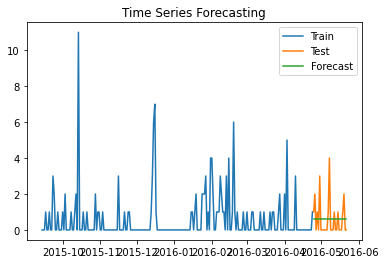

In [499]:
# Visualization
# plt.figure(figsize=(12,12))
plt.plot(ts_train["ds"],ts_train["y"],label="Train")
plt.plot(ts_test["ds"],ts_test["y"],label="Test")
plt.plot(ts_test["ds"],pred,label="Forecast")
plt.title("Time Series Forecasting")
plt.legend()